In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

# Load Dataset

(17998, 96, 96) (17998, 4)
(6000, 96, 96) (6000, 4)


C:\Users\ArcherSeven\anaconda3\envs\efficientnet\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


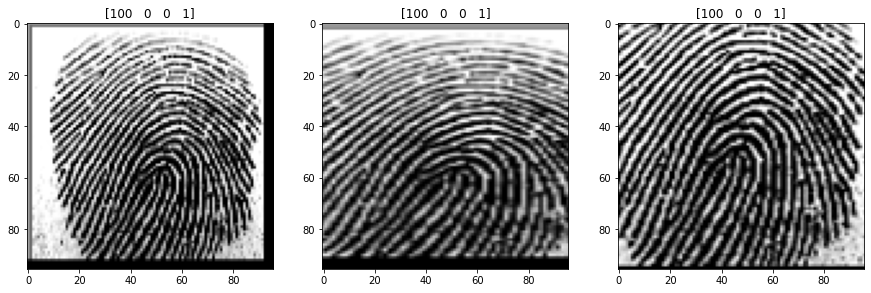

In [2]:
x_real = np.load('dataset/x_real.npz')['data']
y_real = np.load('dataset/y_real.npy')

x_zoom = np.load('dataset/x_zoom.npz')['data']
y_zoom = np.load('dataset/y_zoom.npy')

x_partial = np.load('dataset/x_partial.npz')['data']
y_partial = np.load('dataset/y_partial.npy')

print(x_zoom.shape, y_zoom.shape)
print(x_partial.shape, y_partial.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title(y_zoom[0])
plt.imshow(x_zoom[0].squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title(y_partial[0])
plt.imshow(x_partial[0].squeeze(), cmap='gray')

# Train Test Split

In [3]:
x_train, x_val, label_train, label_val = train_test_split(x_zoom, y_zoom, test_size=0.1)

print(x_zoom.shape, y_zoom.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(17998, 96, 96) (17998, 4)
(16198, 96, 96) (16198, 4)
(1800, 96, 96) (1800, 4)


# Make Label Dictionary Lookup Table

In [4]:
# ID(3)性別(1)左右(1)指頭(1): index
# {'100001': 0, '100004': 1, '100002': 2, ....}
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i
len(label_real_dict)

6000

# Data Generator

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.
        
        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [6]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

# Create Model

In [7]:
x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))

# share weights both inputs
inputs = layers.Input(shape=(96, 96, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)
net = layers.Flatten()(net)
net = layers.Dense(64, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 12, 12, 32)   18816       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 12, 12, 32)   0           ['model[0][0]',            

# Train

In [14]:
from keras.callbacks import EarlyStopping
# 建立 EarlyStopping 物件
es = EarlyStopping(monitor='val_loss', mode='min',
                  verbose=1, patience=5)

from keras.callbacks import ModelCheckpoint
# 建立 ModelCheckpoint 物件
filename = './data/Siamese_zoom.h5'
# filename = './data/Siamese_zoom.hdf5' # val_accuracy
mc = ModelCheckpoint(filename, monitor='val_acc',
                    mode='max', verbose=0,
                    save_best_only=True)

history = model.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=[es, mc])

Epoch 1/50
506/506 [==============================] - 102s 201ms/step - loss: 0.1119 - acc: 0.9559 - val_loss: 0.0515 - val_acc: 0.9816
Epoch 2/50
506/506 [==============================] - 100s 197ms/step - loss: 0.1046 - acc: 0.9616 - val_loss: 0.0444 - val_acc: 0.9849
Epoch 3/50
506/506 [==============================] - 102s 201ms/step - loss: 0.1016 - acc: 0.9621 - val_loss: 0.0281 - val_acc: 0.9911
Epoch 4/50
506/506 [==============================] - 99s 195ms/step - loss: 0.0883 - acc: 0.9678 - val_loss: 0.0325 - val_acc: 0.9888
Epoch 5/50
506/506 [==============================] - 98s 194ms/step - loss: 0.0884 - acc: 0.9670 - val_loss: 0.0424 - val_acc: 0.9844
Epoch 6/50
506/506 [==============================] - 98s 194ms/step - loss: 0.0837 - acc: 0.9681 - val_loss: 0.0295 - val_acc: 0.9900
Epoch 7/50
506/506 [==============================] - 99s 195ms/step - loss: 0.0763 - acc: 0.9721 - val_loss: 0.0216 - val_acc: 0.9927
Epoch 8/50
506/506 [==============================] 

# save model

In [13]:
# 儲存Keras模型
print('Saving Model: Siamese_zoom.h5 ...')
model.save('./data/Siamese_zoom.h5')

Saving Model: Siamese_zoom.h5 ...


# load model

In [11]:
model =  keras.models.load_model('./data/Siamese_zoom.h5')

# Evaluation

In [15]:
match = np.ones((6000,1))
match.shape

(6000, 1)

In [16]:
# 評估模型
print('\nTesting ...')
loss, accuracy = model.evaluate([x_partial.astype(np.float32) / 255.,x_real.astype(np.float32) / 255.], match, verbose=1)
print('測試資料集的準確度 = {:.2f}'.format(accuracy))


Testing ...
188/188 [==============================] - 8s 44ms/step - loss: 1.2864 - acc: 0.6022
測試資料集的準確度 = 0.60


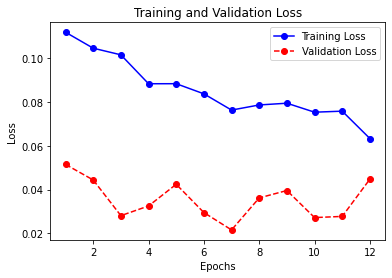

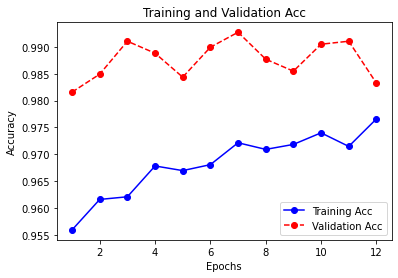

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# 顯示訓練和驗證損失
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# 顯示訓練和驗證準確度 注意 accyracy 要改成 acc，val_accuracy => val_acc，因為keras版本問題
acc = history.history['acc']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo-', label='Training Acc')
plt.plot(epochs, val_acc, 'ro--', label='Validation Acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 102ms/step


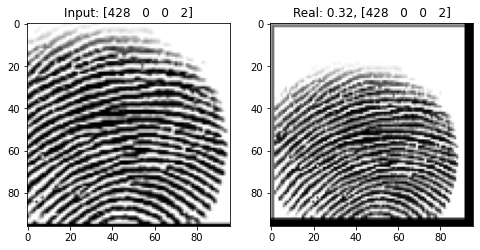

In [18]:
# new user fingerprint input
random_idx = random.randint(0, len(x_partial))

random_img = x_partial[random_idx]
random_label = y_partial[random_idx]

random_img = random_img.reshape((1, 96, 96, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Real: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')